In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/feature_data.csv")

In [3]:
df

,image,emotion,mouth_distance,average_distance,eye_size,eye_brows
0,facial-expressions_2868585k.jpg,7,-28.666667,57.849661,19.570414,-14.0
1,facial-expressions_2868582k.jpg,3,-3.000000,38.702801,17.217604,-13.0
2,Aaron_Peirsol_0003.jpg,4,-13.333333,48.809134,14.625005,-15.5
3,Aaron_Sorkin_0002.jpg,4,-20.000000,54.846611,15.454924,-16.5
4,Abdel_Nasser_Assidi_0002.jpg,5,1.666667,37.752899,16.119976,-17.5
...,...,...,...,...,...,...
24068,SURPRISE/surprise (971).png,7,-3.333333,44.369616,25.488550,-27.0
24069,SURPRISE/surprise (978).jpg,7,-19.666667,63.395024,18.033396,-21.5
24070,SURPRISE/surprise (981).png,7,-47.666667,75.326098,21.125452,-14.5
24071,SURPRISE/surprise (983).jpg,7,-23.333333,65.942962,23.877921,-27.0


In [4]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# create model
clf = svm.SVC(kernel='linear', C=1, probability=True)

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for emo in range(8):
    print(dictionary[emo])

    emo_feature = []
    emo_target = []

    count = 0
    for i in range(len(df['emotion'])):
        if df['emotion'][i] == emo:
            emo_target.append(1)
            count += 1
        else:
            emo_target.append(0)
            
        emo_feature.append([df['mouth_distance'][i], df['average_distance'][i]])

    print(count)
    if count < 10:
        continue

    emo_feature = np.array(emo_feature)
    emo_target = np.array(emo_target)

    # import data
    X = emo_feature
    y = emo_target

    # add noisy features
    random_state = np.random.RandomState(0)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    for i, (train, val) in enumerate(cv.split(X_train, y_train)):
        X_train, X_val = X[train], X[val]
        y_train, y_val = y[train], y[val]

        # fit model
        clf.fit(X_train, y_train)

        # predict
        predict = clf.predict(X_val)
        clf_probs = clf.predict_proba(X_val)

        # store model report in history list
        history.append(classification_report(y_val, predict))

        # get loss and accuracy
        acc = accuracy_score(y_val, predict)
        loss = log_loss(y_val, clf_probs)
        print(f'====================Fold {i}====================', '\n')
        print(f"accuracy_score : {acc}")
        print(f"log_loss : {loss}\n")

        # plot ROC curve
        viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig('graph/' + dictionary[emo] + '/svm_linear.jpg')
    plt.show()

    # for i in range(len(history)):
        # print(f'=========================Fold {i+1}=========================')
        # print(history[i])

    predict = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"specificity: {specificity}\n")
    print(f"sensitivity: {sensitivity}\n")
    print(f"accuracy : {accuracy_score(y_test, predict)}\n")

    # report
    print(classification_report(y_test, predict))
    print(accuracy_score(y_test, predict))

    # plot cofusion matrix
    plot_confusion_matrix(clf, X_test, y_test, cmap='YlOrRd')
    plt.savefig('matrix/' + dictionary[emo] + '/svm_linear.jpg')

    print('\n\n')

ANGER
2517


ANGER
78
====================Fold 0==================== 

accuracy_score : 0.9873125720876585
log_loss : 0.08226174031318537

====================Fold 1==================== 

accuracy_score : 0.9780853517877739
log_loss : 0.1065076659201878



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 2==================== 

accuracy_score : 0.9803695150115473
log_loss : 0.09887269837850365

====================Fold 3==================== 

accuracy_score : 0.9838337182448037
log_loss : 0.08092991998997799

====================Fold 4==================== 

accuracy_score : 0.9849884526558892
log_loss : 0.07779786795100327



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

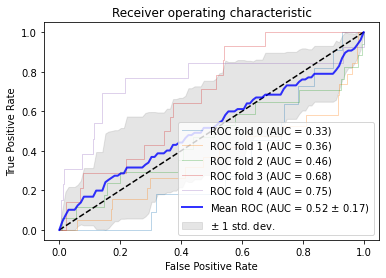

specificity: 1.0

sensitivity: 0.0

accuracy : 0.979253112033195

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       472
           1       0.00      0.00      0.00        10

    accuracy                           0.98       482
   macro avg       0.49      0.50      0.49       482
weighted avg       0.96      0.98      0.97       482

0.979253112033195
CONTEMPT
5
DISGUST


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

6
FEAR
8
HAPPINESS
2359
====================Fold 0==================== 

accuracy_score : 0.7450980392156863
log_loss : 0.54094960200809

====================Fold 1==================== 

accuracy_score : 0.7197231833910035
log_loss : 0.5953379603816573

====================Fold 2==================== 

accuracy_score : 0.7205542725173211
log_loss : 0.6001060299354204

====================Fold 3==================== 

accuracy_score : 0.707852193995381
log_loss : 0.5896724552724156

====================Fold 4==================== 

accuracy_score : 0.710161662817552
log_loss : 0.5779598981606368



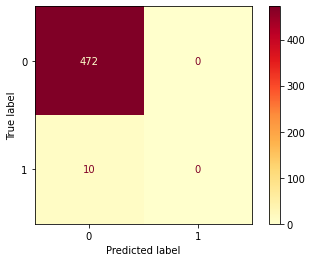

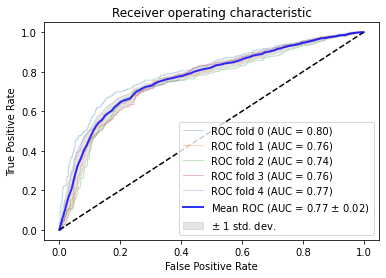

specificity: 0.776

sensitivity: 0.6336206896551724

accuracy : 0.7074688796680498

              precision    recall  f1-score   support

           0       0.70      0.78      0.73       250
           1       0.72      0.63      0.68       232

    accuracy                           0.71       482
   macro avg       0.71      0.70      0.70       482
weighted avg       0.71      0.71      0.71       482

0.7074688796680498
NEUTRAL
2236


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


====================Fold 0==================== 

accuracy_score : 0.7693194925028836
log_loss : 0.5042260832204097

====================Fold 1==================== 

accuracy_score : 0.740484429065744
log_loss : 0.5593362697671594

====================Fold 2==================== 

accuracy_score : 0.745958429561201
log_loss : 0.5614626893132225

====================Fold 3==================== 

accuracy_score : 0.7043879907621247
log_loss : 0.5297484520614626

====================Fold 4==================== 

accuracy_score : 0.7297921478060047
log_loss : 0.5234744626673761



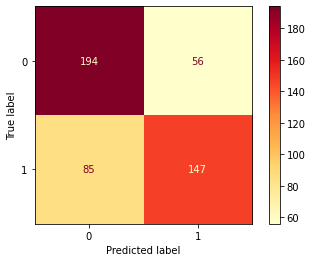

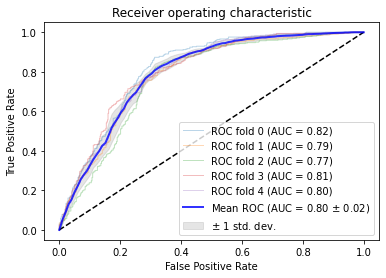

specificity: 0.6436781609195402

sensitivity: 0.8416289592760181

accuracy : 0.7344398340248963

              precision    recall  f1-score   support

           0       0.83      0.64      0.72       261
           1       0.67      0.84      0.74       221

    accuracy                           0.73       482
   macro avg       0.75      0.74      0.73       482
weighted avg       0.75      0.73      0.73       482

0.7344398340248963
SADNESS
36


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division

====================Fold 0==================== 

accuracy_score : 0.9907727797001153
log_loss : 0.06062688873986223

====================Fold 1==================== 

accuracy_score : 0.9953863898500577
log_loss : 0.03028601024358224

====================Fold 2==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.041775430712456416

====================Fold 3==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.041373402339718444

====================Fold 4==================== 

accuracy_score : 0.9953810623556582
log_loss : 0.02991692775871763



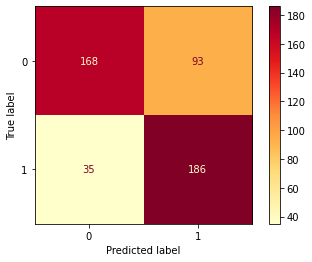

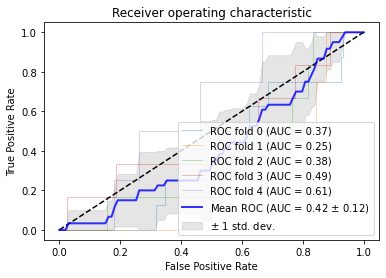

specificity: 1.0

sensitivity: 0.0

accuracy : 0.991701244813278

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       478
           1       0.00      0.00      0.00         4

    accuracy                           0.99       482
   macro avg       0.50      0.50      0.50       482
weighted avg       0.98      0.99      0.99       482

0.991701244813278
SURPRISE
86


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 0==================== 

accuracy_score : 0.986159169550173
log_loss : 0.07416335110924954

====================Fold 1==================== 

accuracy_score : 0.9803921568627451
log_loss : 0.09562348188293934



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 2==================== 

accuracy_score : 0.9734411085450346
log_loss : 0.12554189425110374

====================Fold 3==================== 

accuracy_score : 0.9780600461893765
log_loss : 0.10724331540897106

====================Fold 4==================== 

accuracy_score : 0.9907621247113164
log_loss : 0.05791147251489536



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

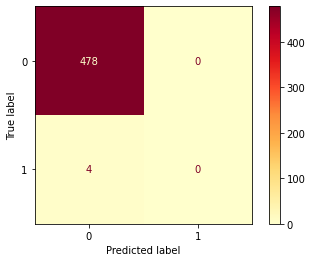

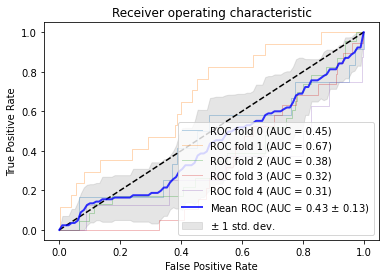

specificity: 1.0

sensitivity: 0.0

accuracy : 0.9730290456431535

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       469
           1       0.00      0.00      0.00        13

    accuracy                           0.97       482
   macro avg       0.49      0.50      0.49       482
weighted avg       0.95      0.97      0.96       482

0.9730290456431535


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

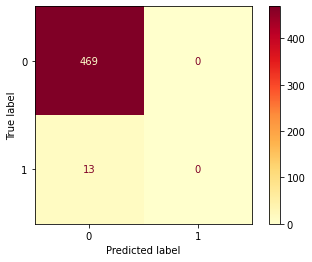

In [ ]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# create model
clf = svm.SVC(kernel='poly', C=1, probability=True)

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for emo in range(8):
    print(dictionary[emo])

    emo_feature = []
    emo_target = []

    count = 0
    for i in range(len(df['emotion'])):
        if df['emotion'][i] == emo:
            emo_target.append(1)
            count += 1
        else:
            emo_target.append(0)
            
        emo_feature.append([df['mouth_distance'][i], df['average_distance'][i]])

    print(count)
    if count < 10:
        continue
    
    emo_feature = np.array(emo_feature)
    emo_target = np.array(emo_target)

    # import data
    X = emo_feature
    y = emo_target

    # add noisy features
    random_state = np.random.RandomState(0)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    for i, (train, val) in enumerate(cv.split(X_train, y_train)):
        X_train, X_val = X[train], X[val]
        y_train, y_val = y[train], y[val]

        # fit model
        clf.fit(X_train, y_train)

        # predict
        predict = clf.predict(X_val)
        clf_probs = clf.predict_proba(X_val)

        # store model report in history list
        history.append(classification_report(y_val, predict))

        # get loss and accuracy
        acc = accuracy_score(y_val, predict)
        loss = log_loss(y_val, clf_probs)
        print(f'====================Fold {i}====================', '\n')
        print(f"accuracy_score : {acc}")
        print(f"log_loss : {loss}\n")

        # plot ROC curve
        viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig('graph/' + dictionary[emo] + '/svm_poly.jpg')
    plt.show()

    # for i in range(len(history)):
        # print(f'=========================Fold {i+1}=========================')
        # print(history[i])

    predict = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"specificity: {specificity}\n")
    print(f"sensitivity: {sensitivity}\n")
    print(f"accuracy : {accuracy_score(y_test, predict)}\n")

    # report
    print(classification_report(y_test, predict))
    print(accuracy_score(y_test, predict))

    # plot cofusion matrix
    plot_confusion_matrix(clf, X_test, y_test, cmap='YlOrRd')
    plt.savefig('matrix/' + dictionary[emo] + '/svm_poly.jpg')

ANGER
78
====================Fold 0==================== 

accuracy_score : 0.9873125720876585
log_loss : 0.08998786080009756



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 1==================== 

accuracy_score : 0.9780853517877739
log_loss : 0.10535704930230137

====================Fold 2==================== 

accuracy_score : 0.9803695150115473
log_loss : 0.09592706326663601



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 3==================== 

accuracy_score : 0.9838337182448037
log_loss : 0.08204882847310069

====================Fold 4==================== 

accuracy_score : 0.9849884526558892
log_loss : 0.07736494263189593



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

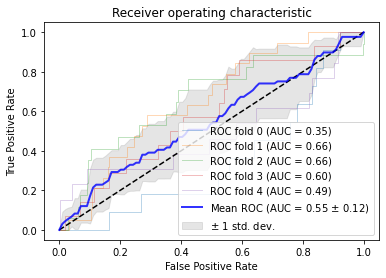

specificity: 1.0

sensitivity: 0.0

accuracy : 0.979253112033195

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       472
           1       0.00      0.00      0.00        10

    accuracy                           0.98       482
   macro avg       0.49      0.50      0.49       482
weighted avg       0.96      0.98      0.97       482

0.979253112033195
CONTEMPT
5
DISGUST


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

6
FEAR
8
HAPPINESS
2359
====================Fold 0==================== 

accuracy_score : 0.748558246828143
log_loss : 0.5385847416405027

====================Fold 1==================== 

accuracy_score : 0.7174163783160323
log_loss : 0.5883141221550027

====================Fold 2==================== 

accuracy_score : 0.7217090069284064
log_loss : 0.5965336166973999

====================Fold 3==================== 

accuracy_score : 0.6928406466512702
log_loss : 0.5819316694656709

====================Fold 4==================== 

accuracy_score : 0.7159353348729792
log_loss : 0.5708903802315697



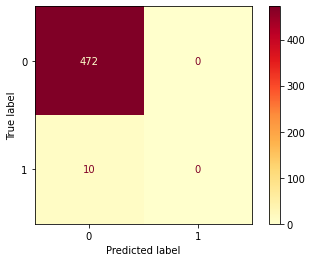

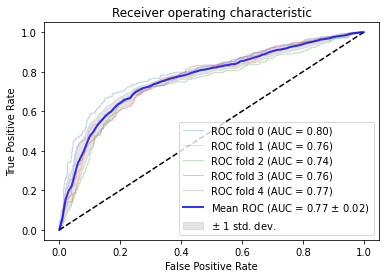

specificity: 0.776

sensitivity: 0.6336206896551724

accuracy : 0.7074688796680498

              precision    recall  f1-score   support

           0       0.70      0.78      0.73       250
           1       0.72      0.63      0.68       232

    accuracy                           0.71       482
   macro avg       0.71      0.70      0.70       482
weighted avg       0.71      0.71      0.71       482

0.7074688796680498


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


NEUTRAL
2236
====================Fold 0==================== 

accuracy_score : 0.7612456747404844
log_loss : 0.50824044643209

====================Fold 1==================== 

accuracy_score : 0.7381776239907728
log_loss : 0.5582197332623635

====================Fold 2==================== 

accuracy_score : 0.7471131639722863
log_loss : 0.5600340140570474

====================Fold 3==================== 

accuracy_score : 0.710161662817552
log_loss : 0.5257263090772051

====================Fold 4==================== 

accuracy_score : 0.7286374133949192
log_loss : 0.5296876961381053



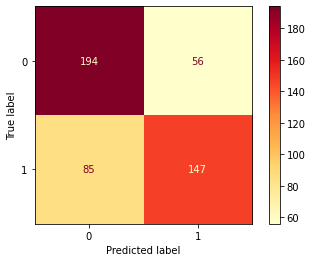

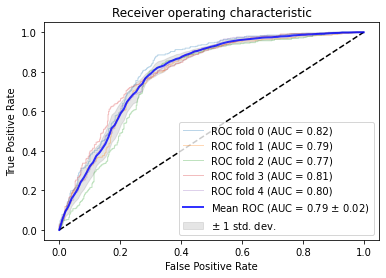

specificity: 0.6819923371647509

sensitivity: 0.8054298642533937

accuracy : 0.7385892116182573

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       261
           1       0.68      0.81      0.74       221

    accuracy                           0.74       482
   macro avg       0.74      0.74      0.74       482
weighted avg       0.75      0.74      0.74       482

0.7385892116182573
SADNESS
36


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division

====================Fold 0==================== 

accuracy_score : 0.9907727797001153
log_loss : 0.053873128639996534

====================Fold 1==================== 

accuracy_score : 0.9953863898500577
log_loss : 0.029978095438127222

====================Fold 2==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.04137526906574475



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 3==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.04150953197051785

====================Fold 4==================== 

accuracy_score : 0.9953810623556582
log_loss : 0.029961732884899867



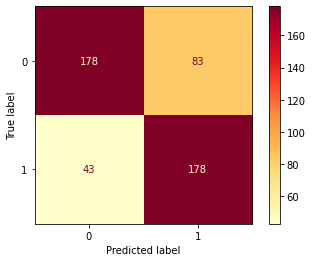

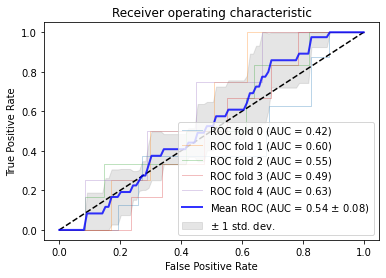

specificity: 1.0

sensitivity: 0.0

accuracy : 0.991701244813278

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       478
           1       0.00      0.00      0.00         4

    accuracy                           0.99       482
   macro avg       0.50      0.50      0.50       482
weighted avg       0.98      0.99      0.99       482

0.991701244813278
SURPRISE
86


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 0==================== 

accuracy_score : 0.986159169550173
log_loss : 0.0952012781911098

====================Fold 1==================== 

accuracy_score : 0.9803921568627451
log_loss : 0.10030345459657507



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 2==================== 

accuracy_score : 0.9734411085450346
log_loss : 0.13319700406358248

====================Fold 3==================== 

accuracy_score : 0.9780600461893765
log_loss : 0.10648555061084176

====================Fold 4==================== 

accuracy_score : 0.9907621247113164
log_loss : 0.056607004081143254



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

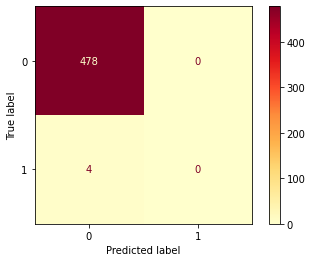

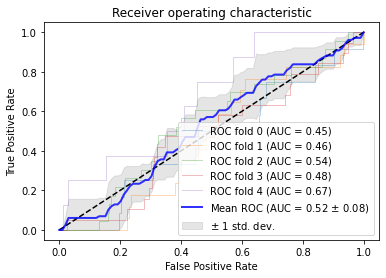

specificity: 1.0

sensitivity: 0.0

accuracy : 0.9730290456431535

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       469
           1       0.00      0.00      0.00        13

    accuracy                           0.97       482
   macro avg       0.49      0.50      0.49       482
weighted avg       0.95      0.97      0.96       482

0.9730290456431535


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

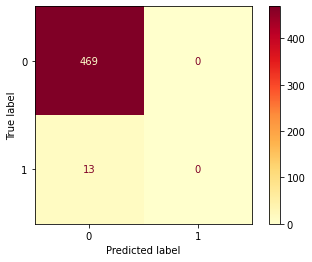

In [ ]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# create model
clf = svm.SVC(kernel='rbf', C=1, probability=True)

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for emo in range(8):
    print(dictionary[emo])

    emo_feature = []
    emo_target = []

    count = 0
    for i in range(len(df['emotion'])):
        if df['emotion'][i] == emo:
            emo_target.append(1)
            count += 1
        else:
            emo_target.append(0)
            
        emo_feature.append([df['mouth_distance'][i], df['average_distance'][i]])

    print(count)
    if count < 10:
        continue

    emo_feature = np.array(emo_feature)
    emo_target = np.array(emo_target)

    # import data
    X = emo_feature
    y = emo_target

    # add noisy features
    random_state = np.random.RandomState(0)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    for i, (train, val) in enumerate(cv.split(X_train, y_train)):
        X_train, X_val = X[train], X[val]
        y_train, y_val = y[train], y[val]

        # fit model
        clf.fit(X_train, y_train)

        # predict
        predict = clf.predict(X_val)
        clf_probs = clf.predict_proba(X_val)

        # store model report in history list
        history.append(classification_report(y_val, predict))

        # get loss and accuracy
        acc = accuracy_score(y_val, predict)
        loss = log_loss(y_val, clf_probs)
        print(f'====================Fold {i}====================', '\n')
        print(f"accuracy_score : {acc}")
        print(f"log_loss : {loss}\n")

        # plot ROC curve
        viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig('graph/' + dictionary[emo] + '/svm_rbf.jpg')
    plt.show()

    # for i in range(len(history)):
        # print(f'=========================Fold {i+1}=========================')
        # print(history[i])

    predict = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"specificity: {specificity}\n")
    print(f"sensitivity: {sensitivity}\n")
    print(f"accuracy : {accuracy_score(y_test, predict)}\n")

    # report
    print(classification_report(y_test, predict))
    print(accuracy_score(y_test, predict))

    # plot cofusion matrix
    plot_confusion_matrix(clf, X_test, y_test, cmap='YlOrRd')
    plt.savefig('matrix/' + dictionary[emo] + '/svm_rbf.jpg')

ANGER
78
====================Fold 0==================== 

accuracy_score : 0.9873125720876585
log_loss : 0.0695135315358018

====================Fold 1==================== 

accuracy_score : 0.9780853517877739
log_loss : 0.10226929839993686

====================Fold 2==================== 

accuracy_score : 0.9803695150115473
log_loss : 0.08799058735832528

====================Fold 3==================== 

accuracy_score : 0.9838337182448037
log_loss : 0.08107060499820395

====================Fold 4==================== 

accuracy_score : 0.9849884526558892
log_loss : 0.06407620378291107



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

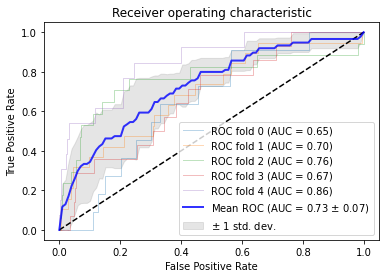

specificity: 1.0

sensitivity: 0.0

accuracy : 0.979253112033195

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       472
           1       0.00      0.00      0.00        10

    accuracy                           0.98       482
   macro avg       0.49      0.50      0.49       482
weighted avg       0.96      0.98      0.97       482

0.979253112033195
CONTEMPT


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

5
DISGUST
6
FEAR
8
HAPPINESS
2359
====================Fold 0==================== 

accuracy_score : 0.7474048442906575
log_loss : 0.5424076562183797

====================Fold 1==================== 

accuracy_score : 0.726643598615917
log_loss : 0.5959042499516664

====================Fold 2==================== 

accuracy_score : 0.7228637413394919
log_loss : 0.6060125182188508

====================Fold 3==================== 

accuracy_score : 0.6986143187066974
log_loss : 0.5931868417186017

====================Fold 4==================== 

accuracy_score : 0.7147806004618937
log_loss : 0.5895438263259696



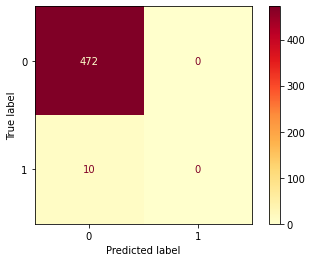

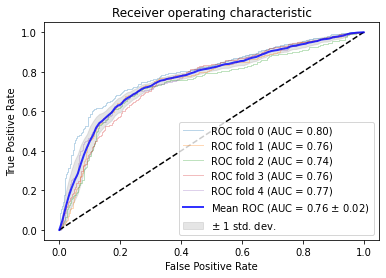

specificity: 0.772

sensitivity: 0.646551724137931

accuracy : 0.7116182572614108

              precision    recall  f1-score   support

           0       0.70      0.77      0.74       250
           1       0.72      0.65      0.68       232

    accuracy                           0.71       482
   macro avg       0.71      0.71      0.71       482
weighted avg       0.71      0.71      0.71       482

0.7116182572614108
NEUTRAL
2236
====================Fold 0==================== 

accuracy_score : 0.7439446366782007
log_loss : 0.5138199828638431

====================Fold 1==================== 

accuracy_score : 0.7324106113033448
log_loss : 0.5632362353637276

====================Fold 2==================== 

accuracy_score : 0.73094688221709
log_loss : 0.5732452088778756



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


====================Fold 3==================== 

accuracy_score : 0.7424942263279446
log_loss : 0.5325794928709358

====================Fold 4==================== 

accuracy_score : 0.73094688221709
log_loss : 0.5349575599981026



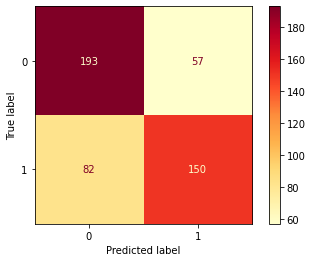

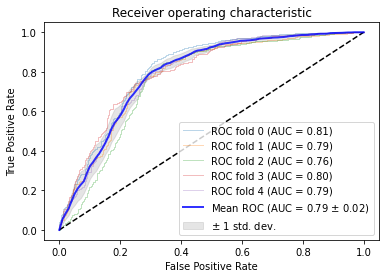

specificity: 0.7279693486590039

sensitivity: 0.7601809954751131

accuracy : 0.7427385892116183

              precision    recall  f1-score   support

           0       0.78      0.73      0.75       261
           1       0.70      0.76      0.73       221

    accuracy                           0.74       482
   macro avg       0.74      0.74      0.74       482
weighted avg       0.75      0.74      0.74       482

0.7427385892116183
SADNESS
36
====================Fold 0==================== 

accuracy_score : 0.9907727797001153
log_loss : 0.05517448579113428



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division

====================Fold 1==================== 

accuracy_score : 0.9953863898500577
log_loss : 0.02969600870817895

====================Fold 2==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.040846854316575906

====================Fold 3==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.04111900114226014

====================Fold 4==================== 

accuracy_score : 0.9953810623556582
log_loss : 0.030757743558371846



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

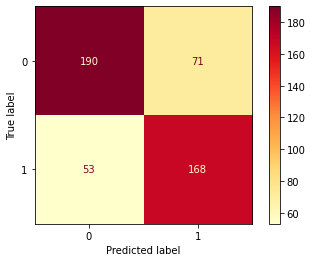

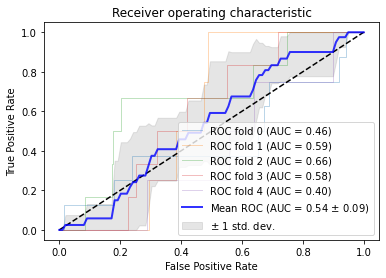

specificity: 1.0

sensitivity: 0.0

accuracy : 0.991701244813278

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       478
           1       0.00      0.00      0.00         4

    accuracy                           0.99       482
   macro avg       0.50      0.50      0.50       482
weighted avg       0.98      0.99      0.99       482

0.991701244813278
SURPRISE
86
====================Fold 0==================== 

accuracy_score : 0.986159169550173
log_loss : 0.07287885811684222

====================Fold 1==================== 

accuracy_score : 0.9803921568627451
log_loss : 0.08344506096513345



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 2==================== 

accuracy_score : 0.9734411085450346
log_loss : 0.11760311860587669

====================Fold 3==================== 

accuracy_score : 0.9780600461893765
log_loss : 0.0969806461206476

====================Fold 4==================== 

accuracy_score : 0.9907621247113164
log_loss : 0.05483092054343402



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

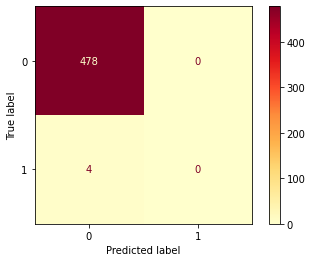

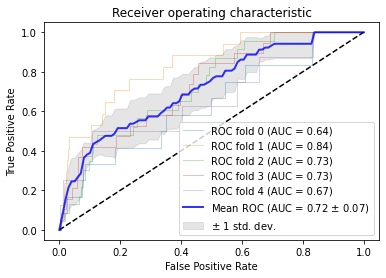

specificity: 1.0

sensitivity: 0.0

accuracy : 0.9730290456431535

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       469
           1       0.00      0.00      0.00        13

    accuracy                           0.97       482
   macro avg       0.49      0.50      0.49       482
weighted avg       0.95      0.97      0.96       482

0.9730290456431535


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

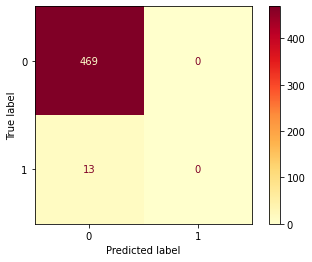

In [ ]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# create model
clf = LogisticRegression()

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for emo in range(8):
    print(dictionary[emo])

    emo_feature = []
    emo_target = []

    count = 0
    for i in range(len(df['emotion'])):
        if df['emotion'][i] == emo:
            emo_target.append(1)
            count += 1
        else:
            emo_target.append(0)
            
        emo_feature.append([df['mouth_distance'][i], df['average_distance'][i]])

    print(count)
    if count < 10:
        continue
    
    emo_feature = np.array(emo_feature)
    emo_target = np.array(emo_target)

    # import data
    X = emo_feature
    y = emo_target

    # add noisy features
    random_state = np.random.RandomState(0)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    for i, (train, val) in enumerate(cv.split(X_train, y_train)):
        X_train, X_val = X[train], X[val]
        y_train, y_val = y[train], y[val]

        # fit model
        clf.fit(X_train, y_train)

        # predict
        predict = clf.predict(X_val)
        clf_probs = clf.predict_proba(X_val)

        # store model report in history list
        history.append(classification_report(y_val, predict))

        # get loss and accuracy
        acc = accuracy_score(y_val, predict)
        loss = log_loss(y_val, clf_probs)
        print(f'====================Fold {i}====================', '\n')
        print(f"accuracy_score : {acc}")
        print(f"log_loss : {loss}\n")

        # plot ROC curve
        viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig('graph/' + dictionary[emo] + '/logreg.jpg')
    plt.show()

    # for i in range(len(history)):
        # print(f'=========================Fold {i+1}=========================')
        # print(history[i])

    predict = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"specificity: {specificity}\n")
    print(f"sensitivity: {sensitivity}\n")
    print(f"accuracy : {accuracy_score(y_test, predict)}\n")

    # report
    print(classification_report(y_test, predict))
    print(accuracy_score(y_test, predict))

    # plot cofusion matrix
    plot_confusion_matrix(clf, X_test, y_test, cmap='YlOrRd')
    plt.savefig('matrix/' + dictionary[emo] + '/logreg.jpg')

ANGER
78
====================Fold 0==================== 

accuracy_score : 0.986159169550173
log_loss : 0.38255946128346313



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 1==================== 

accuracy_score : 0.9780853517877739
log_loss : 0.620549085951602

====================Fold 2==================== 

accuracy_score : 0.9780600461893765
log_loss : 0.4760716079796871

====================Fold 3==================== 

accuracy_score : 0.9803695150115473
log_loss : 0.4671921565412009

====================Fold 4==================== 

accuracy_score : 0.9815242494226328
log_loss : 0.39824363189090584



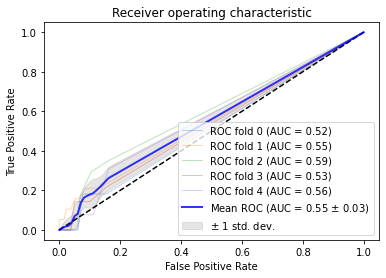

specificity: 1.0

sensitivity: 0.7

accuracy : 0.9937759336099585

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       472
           1       1.00      0.70      0.82        10

    accuracy                           0.99       482
   macro avg       1.00      0.85      0.91       482
weighted avg       0.99      0.99      0.99       482

0.9937759336099585
CONTEMPT
5
DISGUST
6
FEAR


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


8
HAPPINESS
2359
====================Fold 0==================== 

accuracy_score : 0.6793540945790081
log_loss : 1.089833027765316

====================Fold 1==================== 

accuracy_score : 0.6470588235294118
log_loss : 1.079340182252897

====================Fold 2==================== 

accuracy_score : 0.6836027713625866
log_loss : 1.324210271183663

====================Fold 3==================== 

accuracy_score : 0.6270207852193995
log_loss : 1.3917125346846193

====================Fold 4==================== 

accuracy_score : 0.6547344110854504
log_loss : 1.363028340295682



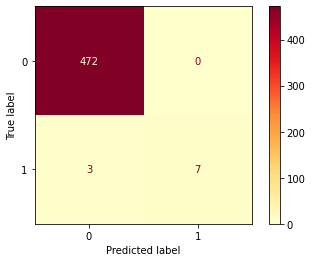

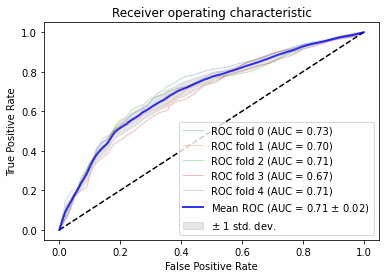

specificity: 0.912

sensitivity: 0.875

accuracy : 0.8941908713692946

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       250
           1       0.90      0.88      0.89       232

    accuracy                           0.89       482
   macro avg       0.89      0.89      0.89       482
weighted avg       0.89      0.89      0.89       482

0.8941908713692946
NEUTRAL
2236


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


====================Fold 0==================== 

accuracy_score : 0.6897347174163783
log_loss : 1.1078295403325804

====================Fold 1==================== 

accuracy_score : 0.6643598615916955
log_loss : 0.9604788388657138

====================Fold 2==================== 

accuracy_score : 0.6766743648960739
log_loss : 1.3429233321240008

====================Fold 3==================== 

accuracy_score : 0.6732101616628176
log_loss : 1.3189203753329939

====================Fold 4==================== 

accuracy_score : 0.687066974595843
log_loss : 1.0436893685270685



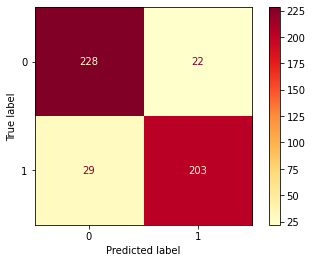

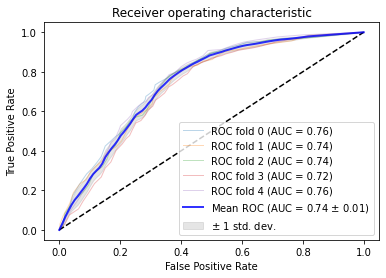

specificity: 0.9003831417624522

sensitivity: 0.8778280542986425

accuracy : 0.8900414937759336

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       261
           1       0.88      0.88      0.88       221

    accuracy                           0.89       482
   macro avg       0.89      0.89      0.89       482
weighted avg       0.89      0.89      0.89       482

0.8900414937759336
SADNESS
36


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division

====================Fold 0==================== 

accuracy_score : 0.9907727797001153
log_loss : 0.32302504554052935

====================Fold 1==================== 

accuracy_score : 0.9953863898500577
log_loss : 0.16634728600429446



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 2==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.24699436661142224

====================Fold 3==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.2472316636523655

====================Fold 4==================== 

accuracy_score : 0.9942263279445728
log_loss : 0.13388997685012058



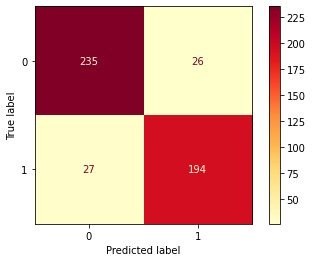

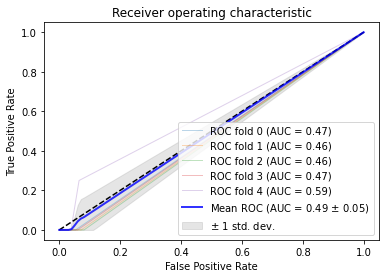

specificity: 1.0

sensitivity: 0.75

accuracy : 0.9979253112033195

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      0.75      0.86         4

    accuracy                           1.00       482
   macro avg       1.00      0.88      0.93       482
weighted avg       1.00      1.00      1.00       482

0.9979253112033195
SURPRISE
86


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


====================Fold 0==================== 

accuracy_score : 0.9850057670126874
log_loss : 0.4245633469910211

====================Fold 1==================== 

accuracy_score : 0.9780853517877739
log_loss : 0.5882739092545404



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 2==================== 

accuracy_score : 0.9734411085450346
log_loss : 0.7452502304992958

====================Fold 3==================== 

accuracy_score : 0.9780600461893765
log_loss : 0.635429843937682

====================Fold 4==================== 

accuracy_score : 0.9872979214780601
log_loss : 0.23251973307353943



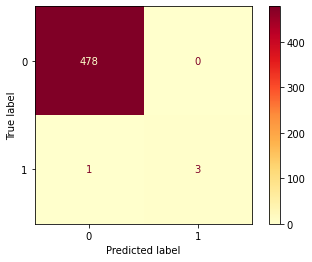

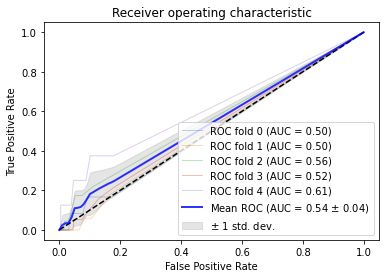

specificity: 1.0

sensitivity: 0.8461538461538461

accuracy : 0.995850622406639

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       469
           1       1.00      0.85      0.92        13

    accuracy                           1.00       482
   macro avg       1.00      0.92      0.96       482
weighted avg       1.00      1.00      1.00       482

0.995850622406639


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


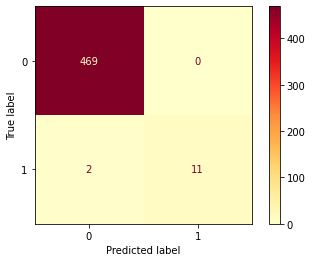

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# create model
clf = RandomForestClassifier(n_estimators=40)

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for emo in range(8):
    print(dictionary[emo])

    emo_feature = []
    emo_target = []

    count = 0
    for i in range(len(df['emotion'])):
        if df['emotion'][i] == emo:
            emo_target.append(1)
            count += 1
        else:
            emo_target.append(0)
            
        emo_feature.append([df['mouth_distance'][i], df['average_distance'][i]])

    print(count)
    if count < 10:
        continue
    
    emo_feature = np.array(emo_feature)
    emo_target = np.array(emo_target)

    # import data
    X = emo_feature
    y = emo_target

    # add noisy features
    random_state = np.random.RandomState(0)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    for i, (train, val) in enumerate(cv.split(X_train, y_train)):
        X_train, X_val = X[train], X[val]
        y_train, y_val = y[train], y[val]

        # fit model
        clf.fit(X_train, y_train)

        # predict
        predict = clf.predict(X_val)
        clf_probs = clf.predict_proba(X_val)

        # store model report in history list
        history.append(classification_report(y_val, predict))

        # get loss and accuracy
        acc = accuracy_score(y_val, predict)
        loss = log_loss(y_val, clf_probs)
        print(f'====================Fold {i}====================', '\n')
        print(f"accuracy_score : {acc}")
        print(f"log_loss : {loss}\n")

        # plot ROC curve
        viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig('graph/' + dictionary[emo] + '/rf.jpg')
    plt.show()

    # for i in range(len(history)):
        # print(f'=========================Fold {i+1}=========================')
        # print(history[i])

    predict = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"specificity: {specificity}\n")
    print(f"sensitivity: {sensitivity}\n")
    print(f"accuracy : {accuracy_score(y_test, predict)}\n")

    # report
    print(classification_report(y_test, predict))
    print(accuracy_score(y_test, predict))

    # plot cofusion matrix
    plot_confusion_matrix(clf, X_test, y_test, cmap='YlOrRd')
    plt.savefig('matrix/' + dictionary[emo] + '/rf.jpg')

ANGER
78
====================Fold 0==================== 

accuracy_score : 0.9780853517877739
log_loss : 0.0922793750729371

====================Fold 1==================== 

accuracy_score : 0.9734717416378316
log_loss : 0.10785923483411244

====================Fold 2==================== 

accuracy_score : 0.976905311778291
log_loss : 0.09002404528247045

====================Fold 3==================== 

accuracy_score : 0.9780600461893765
log_loss : 0.1015384635460862

====================Fold 4==================== 

accuracy_score : 0.9815242494226328
log_loss : 0.06851423881167215



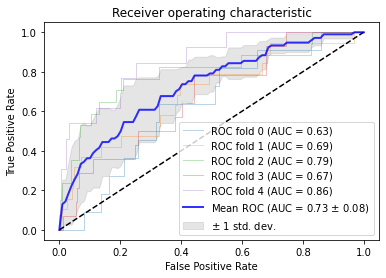

specificity: 0.9978813559322034

sensitivity: 0.1

accuracy : 0.979253112033195

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       472
           1       0.50      0.10      0.17        10

    accuracy                           0.98       482
   macro avg       0.74      0.55      0.58       482
weighted avg       0.97      0.98      0.97       482

0.979253112033195
CONTEMPT
5
DISGUST
6
FEAR


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


8
HAPPINESS
2359
====================Fold 0==================== 

accuracy_score : 0.7289504036908881
log_loss : 0.5595495779182094

====================Fold 1==================== 

accuracy_score : 0.6966551326412919
log_loss : 0.6504950687751414

====================Fold 2==================== 

accuracy_score : 0.7124711316397229
log_loss : 0.6682528748021842

====================Fold 3==================== 

accuracy_score : 0.6859122401847575
log_loss : 0.6257781593966921

====================Fold 4==================== 

accuracy_score : 0.6997690531177829
log_loss : 0.6475164214367892



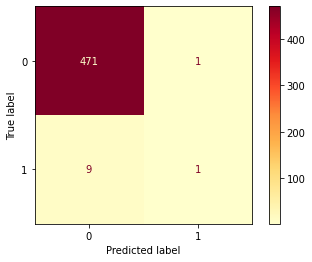

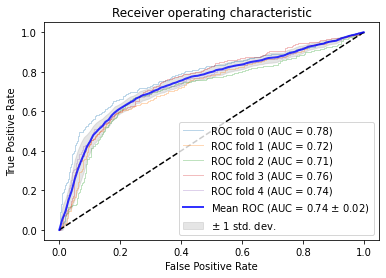

specificity: 0.776

sensitivity: 0.6120689655172413

accuracy : 0.6970954356846473

              precision    recall  f1-score   support

           0       0.68      0.78      0.73       250
           1       0.72      0.61      0.66       232

    accuracy                           0.70       482
   macro avg       0.70      0.69      0.69       482
weighted avg       0.70      0.70      0.69       482

0.6970954356846473
NEUTRAL
2236
====================Fold 0==================== 

accuracy_score : 0.7381776239907728
log_loss : 0.5411444774188958

====================Fold 1==================== 

accuracy_score : 0.7012687427912342
log_loss : 0.6170771033573058

====================Fold 2==================== 

accuracy_score : 0.7344110854503464
log_loss : 0.6196108508854304

====================Fold 3==================== 

accuracy_score : 0.7066974595842956
log_loss : 0.5605773317952465

====================Fold 4==================== 

accuracy_score : 0.7159353348729792
log_loss

C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


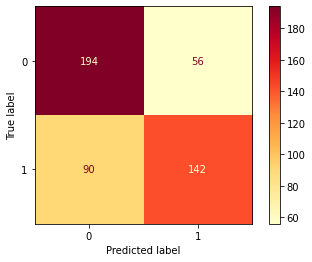

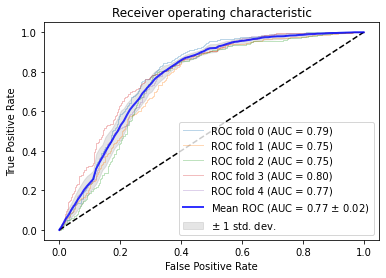

specificity: 0.6513409961685823

sensitivity: 0.8054298642533937

accuracy : 0.7219917012448133

              precision    recall  f1-score   support

           0       0.80      0.65      0.72       261
           1       0.66      0.81      0.73       221

    accuracy                           0.72       482
   macro avg       0.73      0.73      0.72       482
weighted avg       0.74      0.72      0.72       482

0.7219917012448133
SADNESS
36
====================Fold 0==================== 

accuracy_score : 0.9907727797001153
log_loss : 0.06295603457587977

====================Fold 1==================== 

accuracy_score : 0.9953863898500577
log_loss : 0.029133683846608617

====================Fold 2==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.04018075478285105

====================Fold 3==================== 

accuracy_score : 0.9930715935334873
log_loss : 0.04109773430840899

====================Fold 4==================== 

accuracy_score : 0.995381062

C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division

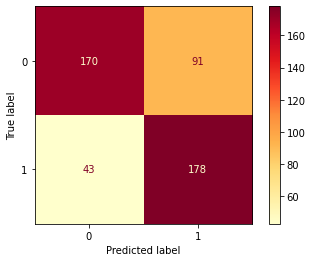

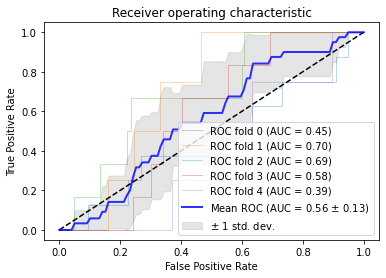

specificity: 1.0

sensitivity: 0.0

accuracy : 0.991701244813278

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       478
           1       0.00      0.00      0.00         4

    accuracy                           0.99       482
   macro avg       0.50      0.50      0.50       482
weighted avg       0.98      0.99      0.99       482

0.991701244813278
SURPRISE
86


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 0==================== 

accuracy_score : 0.9792387543252595
log_loss : 0.08866095351716596

====================Fold 1==================== 

accuracy_score : 0.9803921568627451
log_loss : 0.08069881267249827

====================Fold 2==================== 

accuracy_score : 0.9699769053117783
log_loss : 0.12629994183770954

====================Fold 3==================== 

accuracy_score : 0.9757505773672055
log_loss : 0.10749812630753884

====================Fold 4==================== 

accuracy_score : 0.9815242494226328
log_loss : 0.07905059405231749



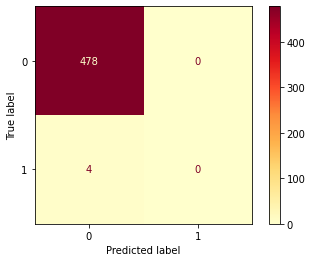

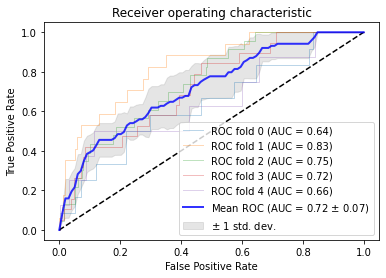

specificity: 0.9914712153518124

sensitivity: 0.0

accuracy : 0.9647302904564315

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       469
           1       0.00      0.00      0.00        13

    accuracy                           0.96       482
   macro avg       0.49      0.50      0.49       482
weighted avg       0.95      0.96      0.96       482

0.9647302904564315


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


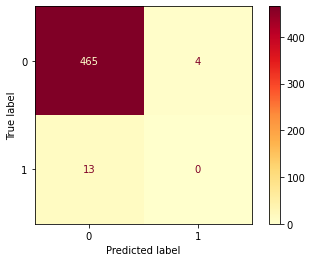

In [ ]:
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# create model
clf = GaussianNB()

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for emo in range(8):
    print(dictionary[emo])

    emo_feature = []
    emo_target = []

    count = 0
    for i in range(len(df['emotion'])):
        if df['emotion'][i] == emo:
            emo_target.append(1)
            count += 1
        else:
            emo_target.append(0)
            
        emo_feature.append([df['mouth_distance'][i], df['average_distance'][i]])

    print(count)
    if count < 10:
        continue

    emo_feature = np.array(emo_feature)
    emo_target = np.array(emo_target)

    # import data
    X = emo_feature
    y = emo_target

    # add noisy features
    random_state = np.random.RandomState(0)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    for i, (train, val) in enumerate(cv.split(X_train, y_train)):
        X_train, X_val = X[train], X[val]
        y_train, y_val = y[train], y[val]

        # fit model
        clf.fit(X_train, y_train)

        # predict
        predict = clf.predict(X_val)
        clf_probs = clf.predict_proba(X_val)

        # store model report in history list
        history.append(classification_report(y_val, predict))

        # get loss and accuracy
        acc = accuracy_score(y_val, predict)
        loss = log_loss(y_val, clf_probs)
        print(f'====================Fold {i}====================', '\n')
        print(f"accuracy_score : {acc}")
        print(f"log_loss : {loss}\n")

        # plot ROC curve
        viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig('graph/' + dictionary[emo] + '/nb.jpg')
    plt.show()

    # for i in range(len(history)):
        # print(f'=========================Fold {i+1}=========================')
        # print(history[i])

    predict = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"specificity: {specificity}\n")
    print(f"sensitivity: {sensitivity}\n")
    print(f"accuracy : {accuracy_score(y_test, predict)}\n")

    # report
    print(classification_report(y_test, predict))
    print(accuracy_score(y_test, predict))

    # plot cofusion matrix
    plot_confusion_matrix(clf, X_test, y_test, cmap='YlOrRd')
    plt.savefig('matrix/' + dictionary[emo] + '/nb.jpg')